In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('seminars/seminar8')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from dgm_utils import train_model, load_dataset, visualize_images, BaseModel, show_samples

device = "cuda" if torch.cuda.is_available() else "cpu"

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 6.12MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 217kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:02<00:00, 554kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.95MB/s]


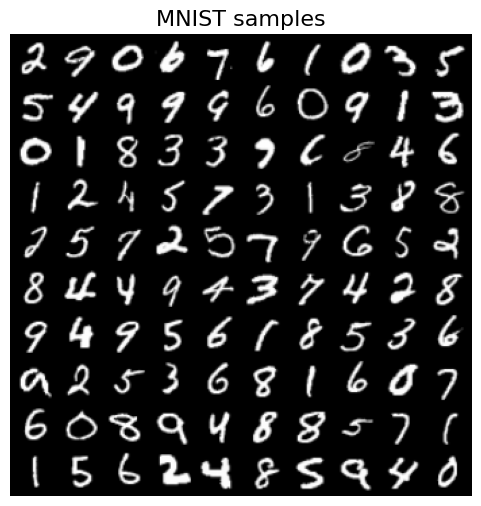

In [3]:
trainset, testset = load_dataset('mnist', binarize=False)
visualize_images(trainset, title='MNIST samples')

In NCSN, sampling looks like iteratively denoising a noisy image to recover data. But instead of learning the gradient of the log-density — what if we directly trained the model to predict the clean image from a noised version?
Would that work? What would we need for that?
<center><img src="pics/ald.gif" width=1200 /></center>

The simplest idea is this: given noise $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$, the model should predict its best estimate of the clean image $\mathbf{x}$ that could have generated it. Once we have this guess, we slightly reduce the noise level, re-corrupt the current estimate to match the new noise level, and feed it back into the model. Repeating this process multiple times allows the model to progressively denoise the sample, moving step-by-step from pure noise toward a coherent image.

Let us first consider the model. To make these predictions, we need a network that takes a noisy image as input and outputs a denoised version. A commonly used architecture for this task is the [U-Net](https://arxiv.org/abs/1505.04597).

<center><img src="pics/unet.png" width=1000 /></center>

In [4]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

To control the amount of corruption, we need a smooth way to interpolate between the data and pure noise.

When the corruption level is 0, we recover the original input $\mathbf{x}$ without any change. As the corruption level approaches 1, the sample becomes indistinguishable from pure noise, losing all trace of $\mathbf{x}$.  

Finally, what should the model do, exactly? Given a corrupted input $x$ the model should output its best guess for what the original $x$ looks like. We will compare this to the actual value via the mean squared error.

In [5]:
class DenoisingNet(BaseModel):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.input_shape = input_shape

        self.model = BasicUNet(
            in_channels=input_shape[0], 
            out_channels=input_shape[0]
        )

    @staticmethod
    def perturbe(x: torch.Tensor, amount: float, device: str = "cpu"):
        noise = torch.rand_like(x).to(device)
        amount = amount.reshape(-1, 1, 1, 1) # Add new deimensions
        return (1 - amount) * x + noise * amount

    def forward(self, x):
        amount = torch.rand(x.shape[0], device=self.device)
        x_noisy = DenoisingNet.perturbe(x, amount, self.device)
        return F.mse_loss(x, self.model(x_noisy))
    
    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}
    
    @torch.no_grad()
    def sample(self, n: int, num_steps: int = 10, return_trajs: bool = False):
        noise = torch.randn(n, *self.input_shape).to(self.device)
        x_clean = self.model(noise)
        if return_trajs:
            traj = [noise.clip(0, 1).cpu()]
            guesses = [x_clean.clip(0, 1).cpu()]
        
        for i in reversed(range(num_steps - 1)):
            amount = torch.tensor([i / (num_steps - 1)] * n).to(self.device)
            x_noisy = DenoisingNet.perturbe(x_clean, amount, self.device)
            x_clean = self.model(x_noisy)
            if return_trajs:
                traj.append(x_noisy.clip(0, 1).cpu())
                guesses.append(x_clean.clip(0, 1).cpu())

        if return_trajs:
            return guesses, traj
        return x_clean.clip(0, 1)

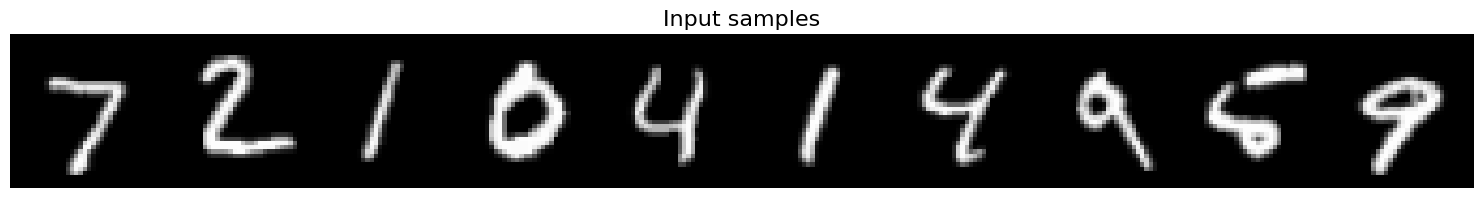

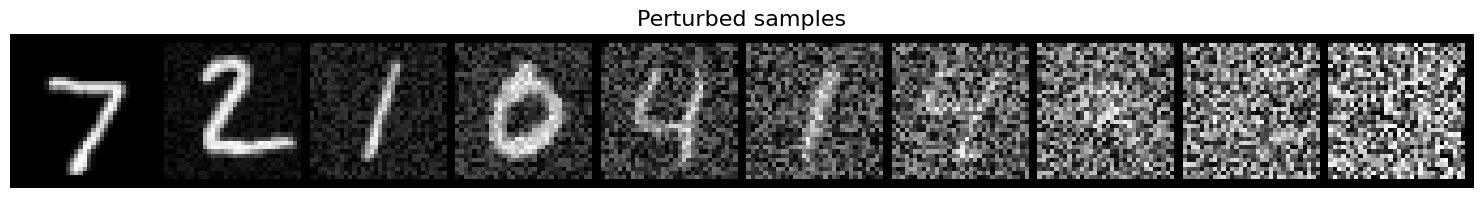

In [6]:
samples_to_perturbe = torch.from_numpy(testset[:10])
show_samples(samples_to_perturbe, title='Input samples', nrow=10, figsize=(20, 2))
amount = torch.linspace(0, 1, 10)

perturbed_samples = DenoisingNet.perturbe(samples_to_perturbe, amount)
show_samples(perturbed_samples, title='Perturbed samples', nrow=10, figsize=(20, 2))

As noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the digit fairly well.

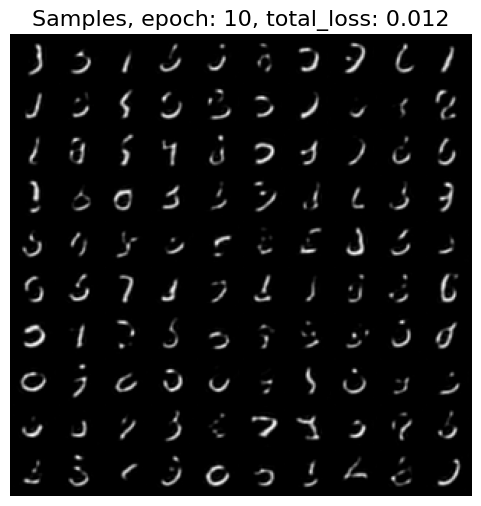

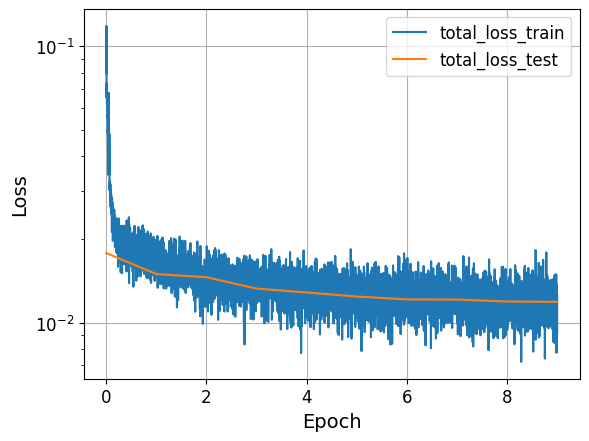

End of the training


In [7]:
model = DenoisingNet().to(device)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=10,
    optimizer=optimizer,
    device=device,
    visualize_samples=True,
    logscale_y=True,
)

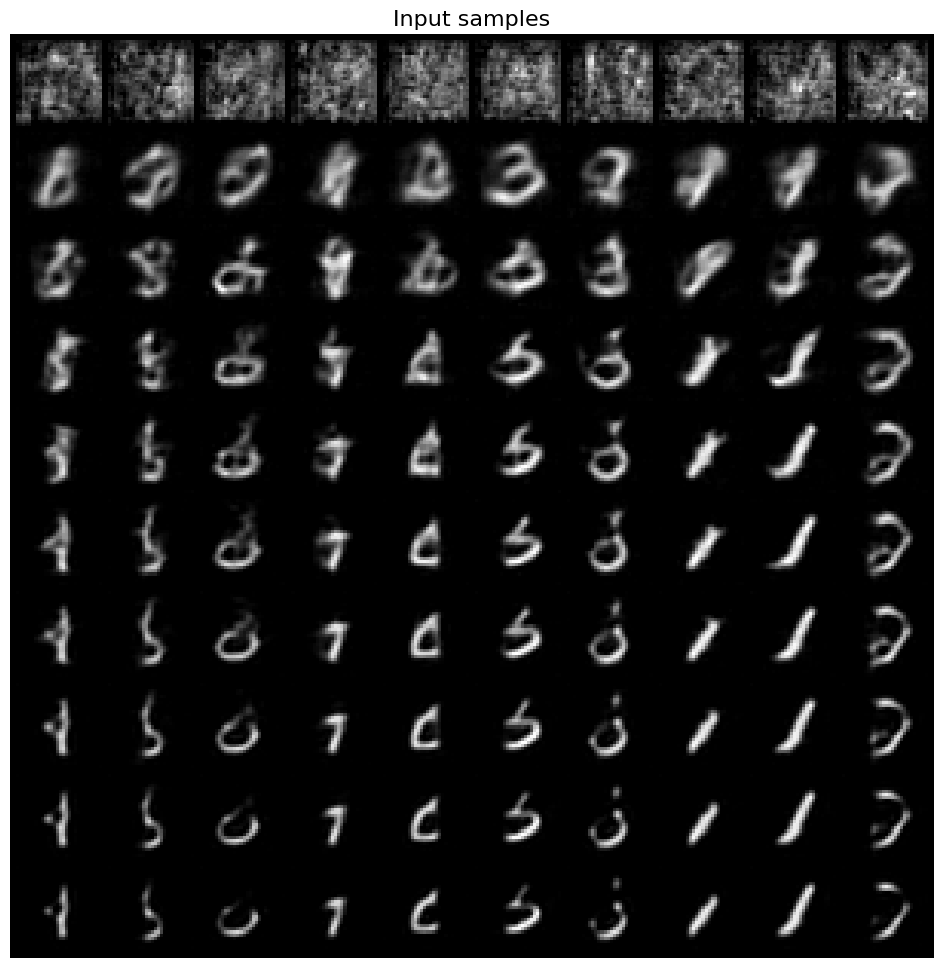

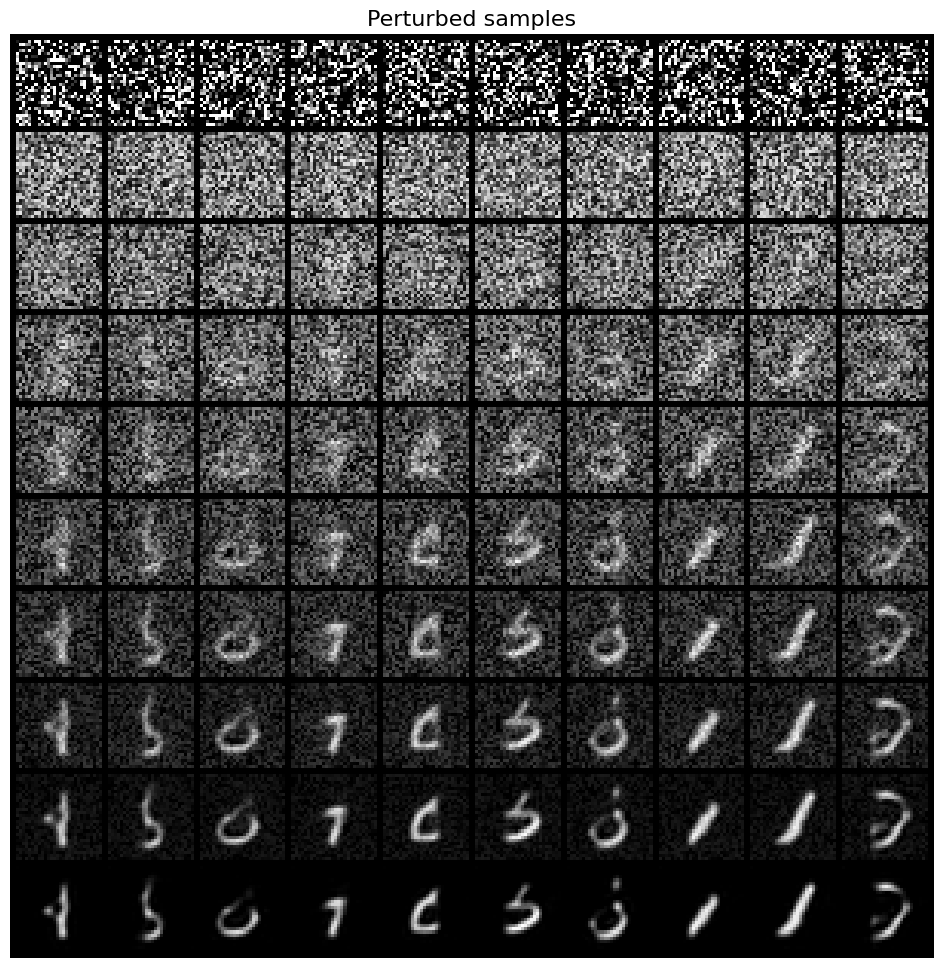

In [8]:
guesses, traj = model.sample(10, return_trajs=True)
guesses = torch.stack(guesses, dim=0).reshape(-1, 1, 28, 28).cpu()
traj = torch.stack(traj, dim=0).reshape(-1, 1, 28, 28).cpu()

show_samples(guesses, title='Input samples', nrow=10, figsize=(12, 12))
show_samples(traj, title='Perturbed samples', nrow=10, figsize=(12, 12))

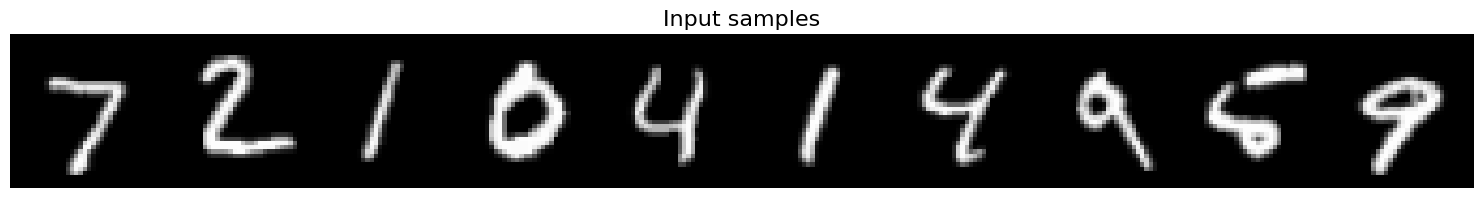

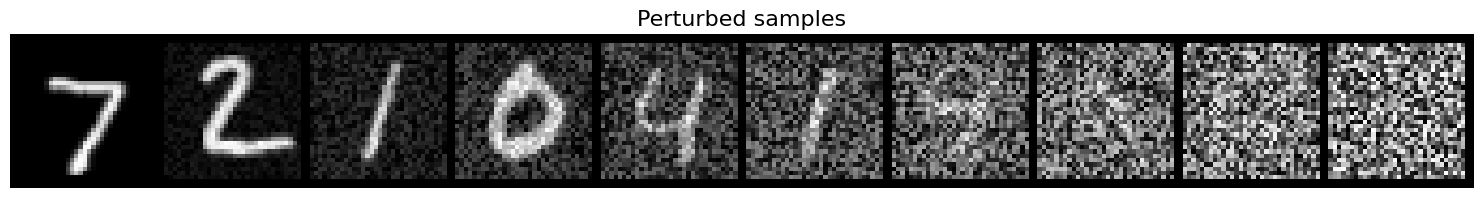

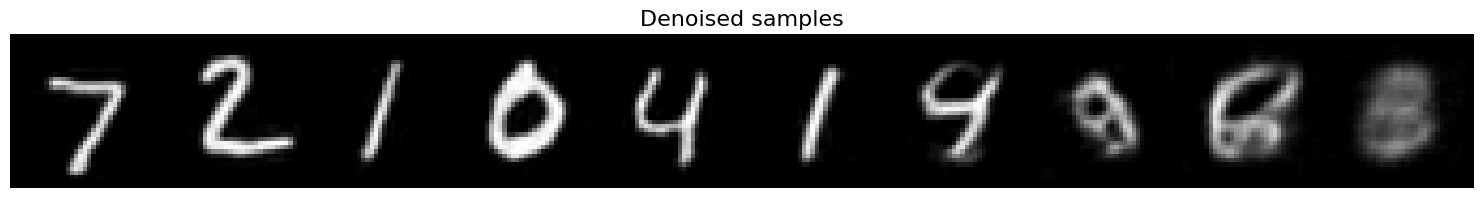

In [9]:
samples_to_perturbe = torch.from_numpy(testset[:10])
show_samples(samples_to_perturbe, title='Input samples', nrow=10, figsize=(20, 2))
amount = torch.linspace(0, 1, 10)

perturbed_samples = DenoisingNet.perturbe(samples_to_perturbe, amount)
show_samples(perturbed_samples, title='Perturbed samples', nrow=10, figsize=(20, 2))

with torch.no_grad():
    denoised_samples = model.model(perturbed_samples.to(device)).cpu().clip(0, 1)
show_samples(denoised_samples, title='Denoised samples', nrow=10, figsize=(20, 2))